In [1]:
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite2d_vrel'
run_name = 'sarsa_nic1'
source_dir = '../data/'+system_name+'/'+run_name+'/'
data_dir = '../data/'+system_name+'/'+run_name+'_eval/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

### Evaluate the environment contained in the source_dir with the best policy already obtained by the training

In [2]:
# READING THE ENVIRONMENTAL PARAMETERS
env_params = ut.read_params(source_dir+'param_env.txt')
print(env_params)

{'int_steps': '0.0005', 'ep_length': '200', 'decision_time': '0.05', 'init_theta': '0.7853981633974483', 'init_dtheta': '0', 'alphas': '-4,0,4,8,12,14,16,18,20,', 'CL_alphas': '0.05,0.35,0.55,0.75,0.9,1.0,1.08,1.1,1.05,', 'CD_alphas': '0.001,0.01,0.03,0.07,0.1,0.13,0.18,0.18,0.21,', 'init_alpha': '10', 'beta_bins': '-3.141592653589793,-3.08,-3.0,-2.9,-2.7,-2.4,-2.1,-1.8,-1.5,-1.2,-0.9,-0.6,-0.3,0.0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,2.9,3.0,3.08,3.141592653589793,', 'wind_type': 'stream', 'k_wind': '0.5', 'eps_wind': '0.2'}


In [3]:
# WRITING THE EVALUATION PARAMETERS
params = dict()
params['alg_type'] = 'eval'
params['policy_path'] = source_dir+'/best_policy.txt'
params['ev_time'] = 200 # sec
params['n_steps'] = params['ev_time']/float(env_params['decision_time'])+1
params['traj_points'] = params['n_steps']
params['gamma'] = 1
ut.write_params(params, data_dir, 'param_alg.txt')

#env_params['ep_length'] = params['ev_time']-1
ut.write_params(env_params, data_dir, 'param_env.txt')

In [4]:
p = subprocess.Popen(["./run.exe", system_name, run_name+'_eval'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print(p.stderr.read().decode('utf-8'))

In [5]:
s_traj, s_labels = ut.read_traj(data_dir+'ev_states.txt')
aux_m, aux_l = ut.read_traj(data_dir+'return_traj.txt')
aggr_s_traj, labels = ut.read_traj(data_dir+'ev_aggr_st.txt')
returns = aux_m[:,0]
ep_length = aux_m[:,1]
aggr_s_ind = np.array(aggr_s_traj[:,0], dtype=float)

In [6]:
period = [50, 50]
def stream_vel(x, y):
    aux1 = np.sin(np.pi*x/period[0])
    aux2 = np.sin(np.pi*y/period[1])
    e = float(env_params['eps_wind'])
    k = float(env_params['k_wind'])
    vx = 0.5*k*y*(2*e*aux1*aux2 + e*np.pi*y/period[1]*aux1*np.cos(np.pi*y/period[1]) + 2)
    vy = -k*e*np.pi*y*y/(2*period[0])*np.cos(np.pi*x/period[0])*aux2;
    return vx, vy

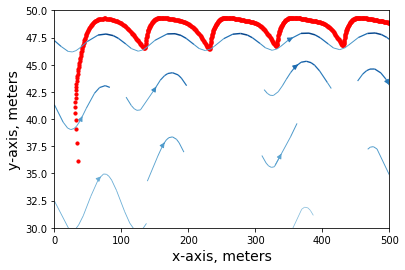

In [7]:
Lx, Ly = np.max(s_traj[:,0]), 50
Y, X = np.mgrid[0:Ly:300j, 0:Lx:300j]
U, V = stream_vel(X,Y)
speed = np.sqrt(U*U + V*V)
plt.streamplot(X, Y, U, V, density=0.6, color=speed, linewidth=speed*0.05, cmap=plt.cm.Blues)
plt.scatter(s_traj[:,0], s_traj[:,1], c='red', s=10)
plt.xlabel('x-axis, meters', fontsize=14)
plt.ylabel('y-axis, meters', fontsize=14)
plt.xlim([0,500])
plt.ylim([30,50])

plt.savefig(plot_dir+'trajectory.png', dpi=200)

/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


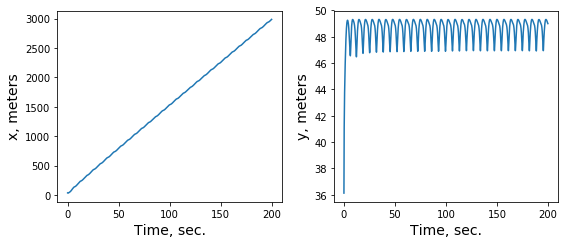

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))

ax1.set_xlabel('Time, sec.', fontsize=14)
ax1.set_ylabel('x, meters', fontsize=14)
xs = np.linspace(0,params['ev_time'],params['traj_points'])
#ax1.set_xlim([0,500])
ax1.plot(xs, s_traj[:,0])

ax2.set_xlabel('Time, sec.', fontsize=14)
ax2.set_ylabel('y, meters', fontsize=14)
#ax2.set_xlim([0,200])
ax2.plot(xs, s_traj[:,1])

plt.tight_layout()
plt.savefig(plot_dir+'traj.png', dpi=200)

In [9]:
beta_bin_list = np.array(env_params['beta_bins'].split(',')[:-1], dtype='float')
beta_list = []
for i in range(len(beta_bin_list)-1):
    beta_list.append((beta_bin_list[i] + beta_bin_list[i+1])/2.0)
alpha_list = np.array(env_params['alphas'].split(',')[:-1], dtype='float')

beta_i = np.array(aggr_s_ind % (len(env_params['beta_bins'].split(','))-2), dtype=int)
alpha_i = np.array(aggr_s_ind // (len(env_params['beta_bins'].split(','))-2), dtype=int)

alphas = alpha_list.take(alpha_i)
betas = np.array(beta_list).take(beta_i)

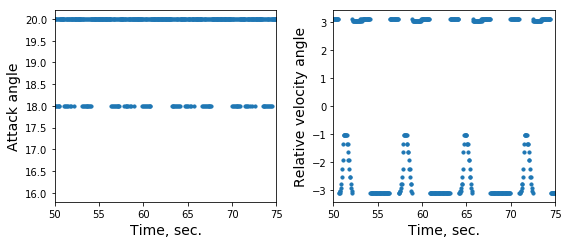

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))

ax1.set_xlabel('Time, sec.', fontsize=14)
ax1.set_ylabel('Attack angle', fontsize=14)
ax1.set_xlim([50,75])
ax1.scatter(xs, alphas, s=10)

ax2.set_xlabel('Time, sec.', fontsize=14)
ax2.set_ylabel('Relative velocity angle', fontsize=14)
ax2.set_xlim([50,75])
ax2.scatter(xs, betas, s=10)

plt.tight_layout()
plt.savefig(plot_dir+'aggr_states.png', dpi=200)

In [11]:
best_p_file = open(source_dir+'best_policy.txt')
best_p=[]
for l in best_p_file.readlines():
    best_p.append(l.split(' '))
best_p = np.array(best_p, dtype='float')

In [12]:
best_a = []
for p in best_p:
    if p[0] == 1:
        best_a.append(0)
    elif p[1] == 1:
        best_a.append(1)
    else:
        best_a.append(2)

In [13]:
import seaborn as sns

In [14]:
alphas_l = np.array(env_params['alphas'].split(',')[:-1], dtype=float)
beta_bins = np.array(env_params['beta_bins'].split(',')[:-1], dtype=float)
betas_l = [str((beta_bins[i+1]+beta_bins[i])/2)[:5] for i in range(len(beta_bins)-1)]
best_a_mat = np.zeros((len(alphas_l),len(betas_l)))
for a_i in range(len(alphas_l)):
    for b_i in range(len(betas_l)):
        index = b_i + len(betas_l)*a_i
        best_a_mat[a_i,b_i] = best_a[index]

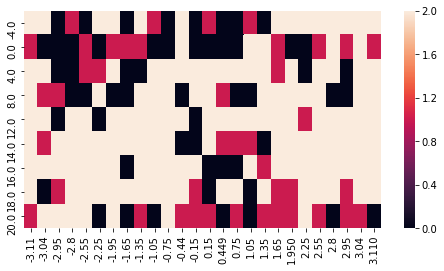

In [15]:
fig = plt.figure(figsize=(8,4))
sns.heatmap(best_a_mat, xticklabels=betas_l, yticklabels=alphas_l)

In [19]:
count_mat = np.zeros((len(alphas_l),len(betas_l)))
for t in range(len(alphas)):
    count_mat[alpha_i[t], beta_i[t]] += 1

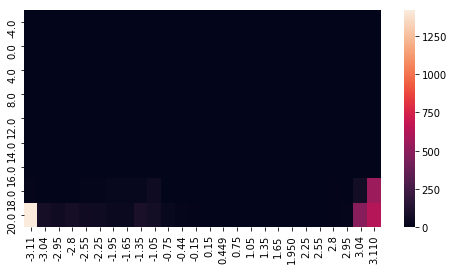

In [20]:
fig = plt.figure(figsize=(8,4))
sns.heatmap(count_mat, xticklabels=betas_l, yticklabels=alphas_l)